# Elliptic AML Dataset Exploration
Initial exploration and visualization of the dataset.

###  Workflow Overview

This notebook performs the following steps:

1. Load and inspect raw CSV files from the Elliptic dataset
2. Construct a transaction graph using NetworkX
3. Calculate key graph metrics (e.g., PageRank, Degree)
4. Identify the largest connected component (LCC)
5. Visualize graph structure
6. Prepare for merging features and labels for classification



### Extract zip file

In [32]:
import zipfile
import os

# zip file and extract file path
zip_path = "../data/raw/archive.zip"
extract_path = "../data/"

# extract or not
def is_dataset_extracted(path):
    return os.path.exists(path) and any(fname.endswith(".csv") for fname in os.listdir(path))

# extract
if not is_dataset_extracted(extract_path):
    try:
        os.makedirs(extract_path, exist_ok=True)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Dataset extracted successfully.")
    except FileNotFoundError:
        print(f"❌ File not found: {zip_path}")
        print("👉 Please make sure the dataset .zip file exists at the path above.")
else:
    print("✅ Dataset already extracted.")


✅ Dataset extracted successfully.


### Loading the Dataset

We load the three core CSV files: node features, edge list, and class labels.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import networkx as nx

features_df = pd.read_csv("../data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
edges_df = pd.read_csv("../data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
classes_df = pd.read_csv("../data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")



###  Exploring Dataset Shapes and Missing Values

Let’s inspect the number of rows and columns in each dataset and identify any missing values.

In [13]:
print("Features shape:", features_df.shape)
print("Edges shape:", edges_df.shape)
print("Classes shape:", classes_df.shape)

print("Missing values in features:", features_df.isna().sum().sum())

Features shape: (203769, 167)
Edges shape: (234355, 2)
Classes shape: (203769, 2)
Missing values in features: 0


### Visualizing Class Distribution

We plot how many transactions are labeled as illicit, licit, or unknown.

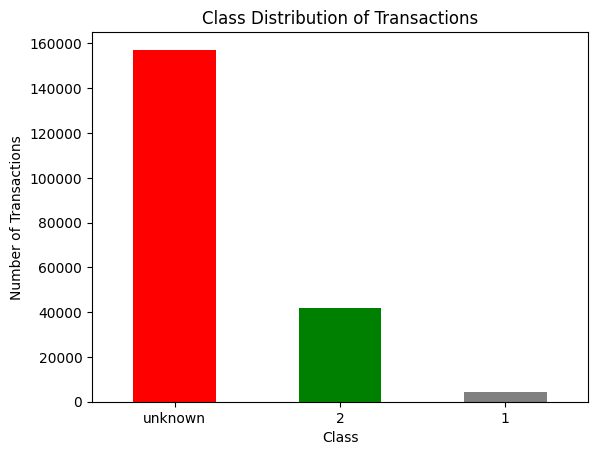

In [14]:
class_counts = classes_df["class"].value_counts()
class_counts.plot(kind="bar", color=["red", "green", "gray"])
plt.title("Class Distribution of Transactions")
plt.xticks(rotation=0)
plt.xlabel("Class")
plt.ylabel("Number of Transactions")
plt.show()

### Class Distribution

- The majority of transactions (~158k) are labeled as **unknown**.
- Legitimate (class 2) transactions are around ~42k, while illicit (class 1) transactions are only ~4k.
- This is a **heavily imbalanced classification problem**, common in fraud detection.
- We will need to consider strategies like class weights or oversampling later.

### Constructing and Inspecting the Transaction Graph

We use NetworkX to construct a graph and inspect its basic statistics.

In [20]:
G = nx.from_pandas_edgelist(edges_df, "txId1", "txId2")

print("✅ Graph Summary:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed?: {G.is_directed()}")
print(f"Number of connected components: {nx.number_connected_components(G)}")


✅ Graph Summary:
Number of nodes: 203769
Number of edges: 234355
Is directed?: False
Number of connected components: 49


### Transaction Graph Structure

- Total nodes: `203,769`, Edges: `234,355`.
- The graph is **undirected** and contains `49` connected components.
- This means some transaction networks are isolated.
- Understanding graph structure helps us later apply graph algorithms or GNNs.

### Graph Centrality Measures
In this step, centrality measures help identify *important nodes* in the transaction graph.
We compute:
- **Degree Centrality**: Measures how many direct connections a node has.
- **PageRank**: Captures the influence of a node in the graph.
These metrics allow us to detect potentially suspicious accounts that play a key role in the money flow network — possibly acting as intermediaries or "mixers".

In [25]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

#PageRank
pagerank_scores = nx.pagerank(G)

# Convert to DataFrame
centrality_df = pd.DataFrame({
    "txId": list(degree_centrality.keys()),
    "degree_centrality": list(degree_centrality.values()),
    "pagerank": list(pagerank_scores.values())
})
centrality_df.head()


,txId,degree_centrality,pagerank
0,230425980,0.000010,0.000005
1,5530458,0.000010,0.000005
2,232022460,0.000015,0.000006
3,232438397,0.000790,0.000244
4,230460314,0.000049,0.000009


### Visualizing Subgraphs or Communities
We plot a sample subgraph to understand the network structure and spot potential community clusters or suspicious flows.


In [29]:
# 重新获取 top 100 节点（按 degree centrality 排名）
top_nodes = centrality_df.sort_values("degree_centrality", ascending=False).head(100)["txId"].tolist()

# 从原始图中提取子图
sample_subG = G.subgraph(top_nodes)


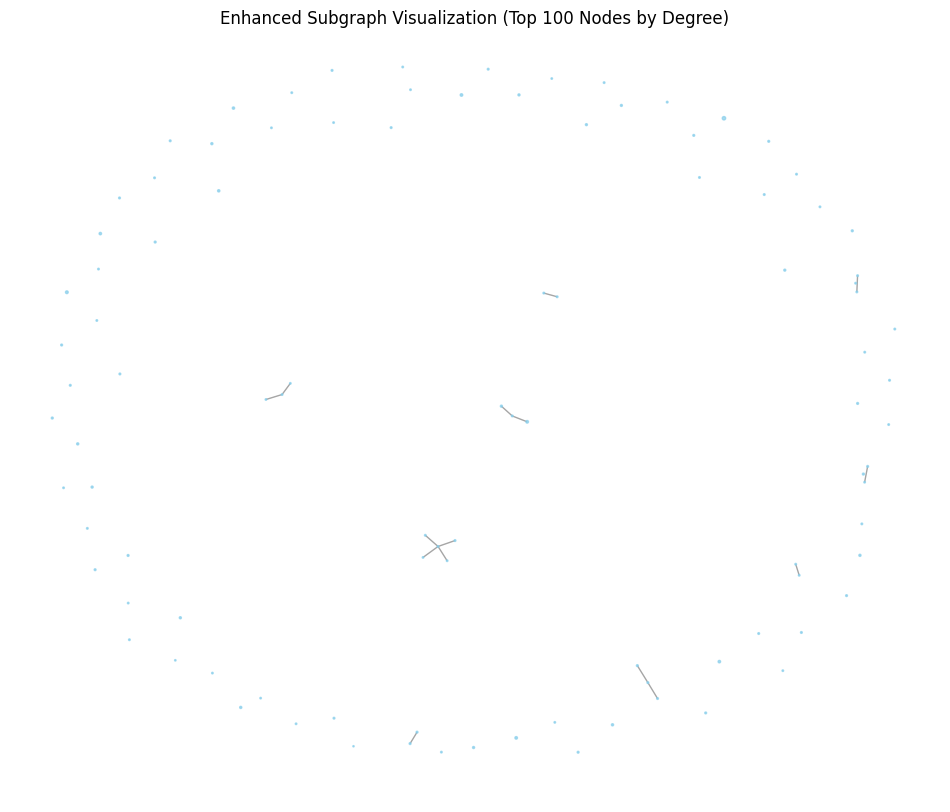

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# 使用 spring layout（弹簧布局）
pos = nx.spring_layout(sample_subG, seed=42)

# 节点大小：用 PageRank 表示影响力
node_sizes = [pagerank_scores.get(n, 0) * 10000 for n in sample_subG.nodes()]

# 绘图
nx.draw_networkx(
    sample_subG, 
    pos, 
    with_labels=False, 
    node_size=node_sizes,
    node_color='skyblue', 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Enhanced Subgraph Visualization (Top 100 Nodes by Degree)")
plt.axis("off")
plt.show()


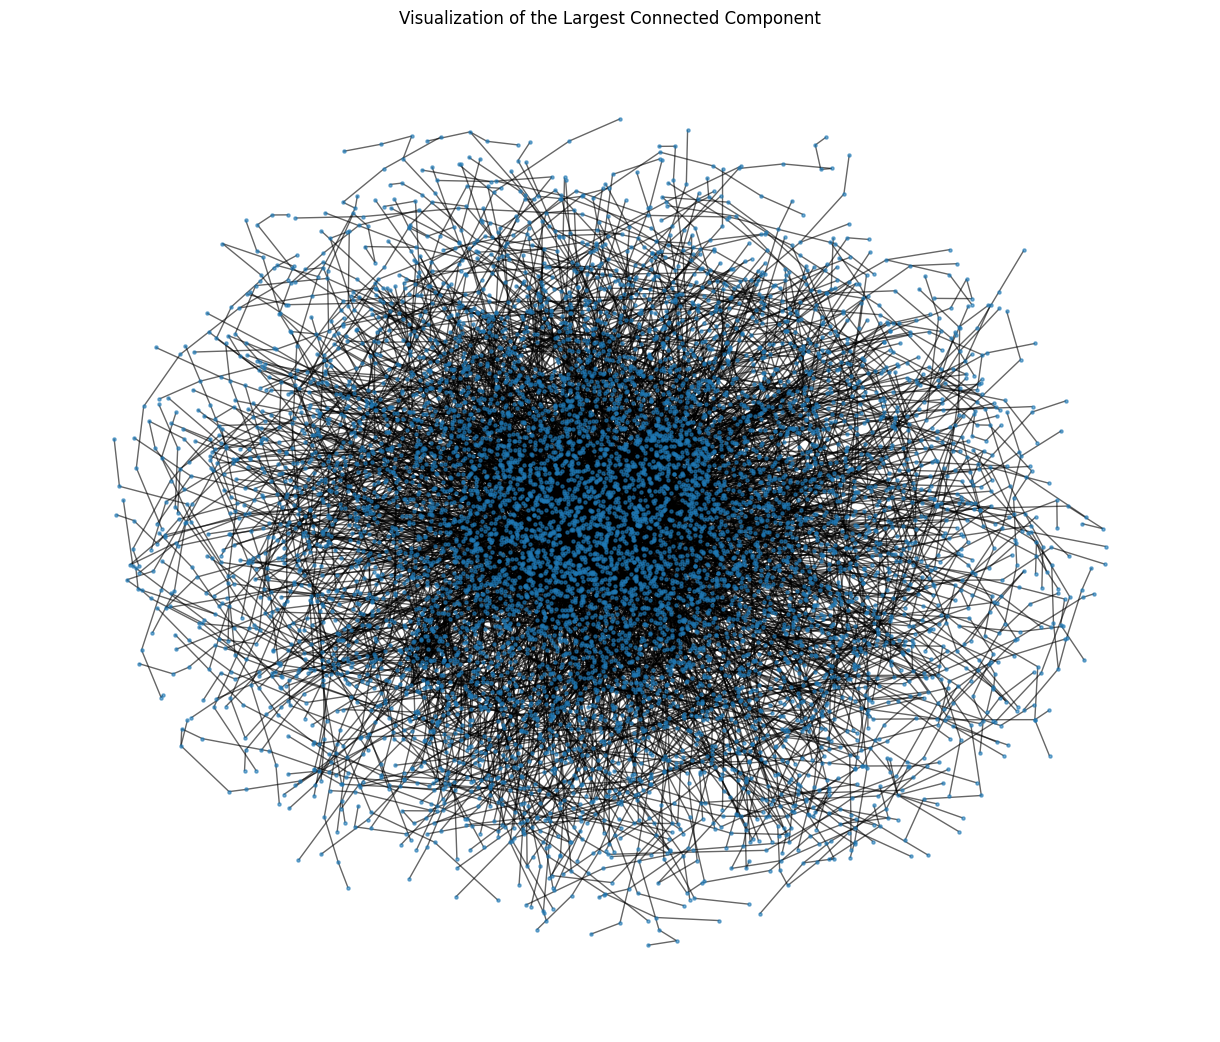

In [31]:
# 获取最大连通子图
components = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
largest_cc = G.subgraph(components[0])

# 可视化这个最大子图（而不是前100节点）
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(largest_cc, seed=42)
nx.draw(largest_cc, pos, node_size=5, alpha=0.6)
plt.title("Visualization of the Largest Connected Component")
plt.show()


### Why We Visualize the Largest Connected Component?

While the top-degree nodes appeared structurally disconnected, the largest connected component (LCC) provides a much more meaningful snapshot of the actual transaction network.

The LCC contains all nodes that are reachable from one another, making it a suitable candidate for:

- Fraud detection using graph-based models
- Community detection or role inference
- Graph Neural Networks (GNN) input preprocessing

Although the full graph may contain many isolated or irrelevant nodes, the LCC reflects the *core transaction structure* where laundering and propagation likely happen.

In fraud analytics, analyzing the LCC helps us focus on the *network backbone* — where the real action is.


### Merging Features + Labels
We merge transaction features, graph centrality scores, and fraud labels to build a dataset for modeling.

In [27]:
# Merge features with centrality
features_df["txId"] = classes_df["txId"]
merged_df = features_df.merge(centrality_df, on="txId", how="left")

# Add labels
merged_df["label"] = classes_df["class"]

# Check result
merged_df.head()


,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,txId,degree_centrality,pagerank,label
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,0.000010,0.000005,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,0.000010,0.000005,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,0.000015,0.000006,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0.000790,0.000244,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,0.000049,0.000009,unknown


## Next Steps

Coming up in the next notebook:

- Merge node features with labels
- Train machine learning and GNN models
- Explore anomaly detection approaches
